[View in Colaboratory](https://colab.research.google.com/github/hyerim1048/100_pytorch/blob/master/pytorch_batchnorm.ipynb)

In [1]:
!pip3 install torch

    100% |████████████████████████████████| 484.0MB 12kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5b1d2000 @  0x7fca7c6981c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8


In [0]:
import torch
from torch.autograd import Variable
from torch import nn
from torch.nn import init
import torch.utils.data as Data
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

torch.manual_seed(1)    # reproducible
np.random.seed(1)

In [0]:
# Hyper parameters
N_SAMPLES = 2000
BATCH_SIZE = 64
EPOCH = 12
LR = 0.03
N_HIDDEN = 8
ACTIVATION = F.tanh
B_INIT = -0.2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if sys.path[0] == '':


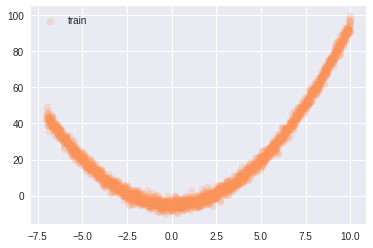

In [6]:
# 임의로 데이터 준비

# training data
x = np.linspace(-7, 10, N_SAMPLES)[:, np.newaxis]
noise = np.random.normal(0, 2, x.shape)
y = np.square(x) - 5 + noise

# test data
test_x = np.linspace(-7, 10, 200)[:, np.newaxis]
noise = np.random.normal(0, 2, test_x.shape)
test_y = np.square(test_x) - 5 + noise

train_x, train_y = torch.from_numpy(x).float(), torch.from_numpy(y).float()
test_x = Variable(torch.from_numpy(test_x).float(), volatile=True)  # not for computing gradients
test_y = Variable(torch.from_numpy(test_y).float(), volatile=True)

train_dataset = Data.TensorDataset(train_x, train_y)
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,)

# show data
plt.scatter(train_x.numpy(), train_y.numpy(), c='#FF9359', s=50, alpha=0.2, label='train')
plt.legend(loc='upper left')

In [0]:
## torch.nn.BatchNorm1d(num_features, eps=1e-05,momentum=0.1, affine=true, tracj_running_stats=True)

mini-batch마다 standard-deviation과 평균을 계산 한 후에 learnable gamma와 beta를 넣어줌.



In [0]:
class Net(nn.Module):
    def __init__(self, batch_normalization=False):
        super(Net, self).__init__()
        self.do_bn = batch_normalization
        self.fcs = []
        self.bns = []
        self.bn_input = nn.BatchNorm1d(1, momentum=0.5)   # 1d input batch norm

        for i in range(N_HIDDEN):               # build hidden layers and BN layers
            input_size = 1 if i == 0 else 10 # 처음에는 1 
            fc = nn.Linear(input_size, 10) # input size * 10 neural net
            setattr(self, 'fc%i' % i, fc)       # IMPORTANT set layer to the Module
            self._set_init(fc)                  # parameters initialization
            self.fcs.append(fc)
            if self.do_bn:
                bn = nn.BatchNorm1d(10, momentum=0.5)
                setattr(self, 'bn%i' % i, bn)   # IMPORTANT set layer to the Module
                self.bns.append(bn)

### 여기 추가해야함 ########

    def forward(self, x):
        pre_activation = [x]
        if self.do_bn: x = self.bn_input(x)     # 여기서 input에 batch normalization
        layer_input = [x]
        for i in range(N_HIDDEN): # Hidden State크기 만큼
            x = self.fcs[i](x) #
            pre_activation.append(x)
            if self.do_bn: x = self.bns[i](x)   # batch normalization
            x = ACTIVATION(x)
            layer_input.append(x)
        out = self.predict(x)
        return out, layer_input, pre_activation